In [1]:
source('source.r')

load('RStates/ship.final.2min.rdata')
load('RStates/mld-0.1.rdata')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘R.matlab’”Loading required package: openxlsx
Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Loading required package: geosphere
Loading required package: readxl
Loading required package: data.table
Loading required package: rworldmap
Loading required package: sp
### Welcome to rworldmap ###
For a short introduction type : 	 vignette('rworldmap')
Loading required package: rworldxtra


In [2]:
ctd = read.xlsx('Raw Data/CTD/DataZoo - P1706 CTD Downcast Data.xlsx')
ctd$Time = conv_excel_time(ctd$DateTime_GMT, tz = 'UTC')

ctd.log = read.xlsx('Raw Data/CTD/DataZoo - P1706 CTD Cast Log.xlsx', sheet='Data')

#ship.log = read.xlsx('Raw Data/CCEP1706 Event Log.xlsx')

str(ctd)
str(ctd.log)
#str(ship.log)

'data.frame':	41780 obs. of  35 variables:
 $ Cruise      : chr  "CCE-P1706" "CCE-P1706" "CCE-P1706" "CCE-P1706" ...
 $ Cycle       : chr  "Cycle0" "Cycle0" "Cycle0" "Cycle0" ...
 $ EventNo     : num  3 3 3 3 3 3 3 3 3 3 ...
 $ Cast        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ DateTime_GMT: num  42888 42888 42888 42888 42888 ...
 $ Direction   : chr  "down" "down" "down" "down" ...
 $ Pressure    : num  2 3 4 5 6 7 8 9 10 11 ...
 $ Depth       : num  1.99 2.98 3.97 4.96 5.96 ...
 $ T090C       : num  16.9 16.8 16.9 16.9 16.8 ...
 $ T190C       : num  16.8 16.8 16.9 16.9 16.8 ...
 $ Cond1       : num  4.3 4.29 4.3 4.3 4.29 ...
 $ Cond2       : num  4.29 4.29 4.3 4.3 4.3 ...
 $ Sal00       : num  33.4 33.4 33.4 33.4 33.4 ...
 $ Sal11       : num  33.4 33.4 33.4 33.4 33.4 ...
 $ OxymicroM   : num  195 196 195 195 195 ...
 $ OxyPerSat   : num  81 81.1 81 80.9 80.8 ...
 $ SurPAR      : num  8632 8632 8632 8632 8632 ...
 $ PAR         : num  1292 1053 887 775 688 ...
 $ Cpar        : num  0.1496

## Plot some summary profiles

In [3]:
plot.cycle = function(cycle = 'Cycle0') {
    l = which(ctd$Cycle == cycle)
    plot(ctd$Sal00[l], ctd$Depth[l], pch=20, cex=0.8, col='#00000090', ylim=c(100,0), ylab='Depth',
         xaxs='i', yaxs='i', main=cycle, xlab='Fluor', xlim = c(32.8,34.1))
}
unique(ctd$Cycle)

[1] "Cycle0"    "Transect1" "Cycle1"    "Cycle2"    "Transect2" "Cycle3"   
 [7] "Transect3" "Cycle4"    "BBL"       "TransComp"

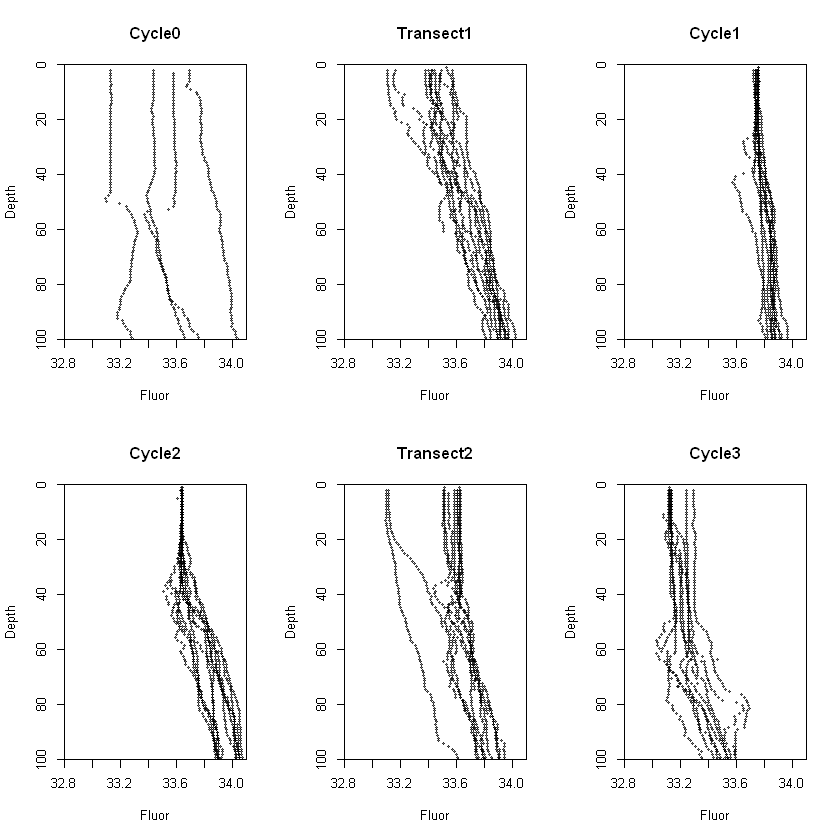

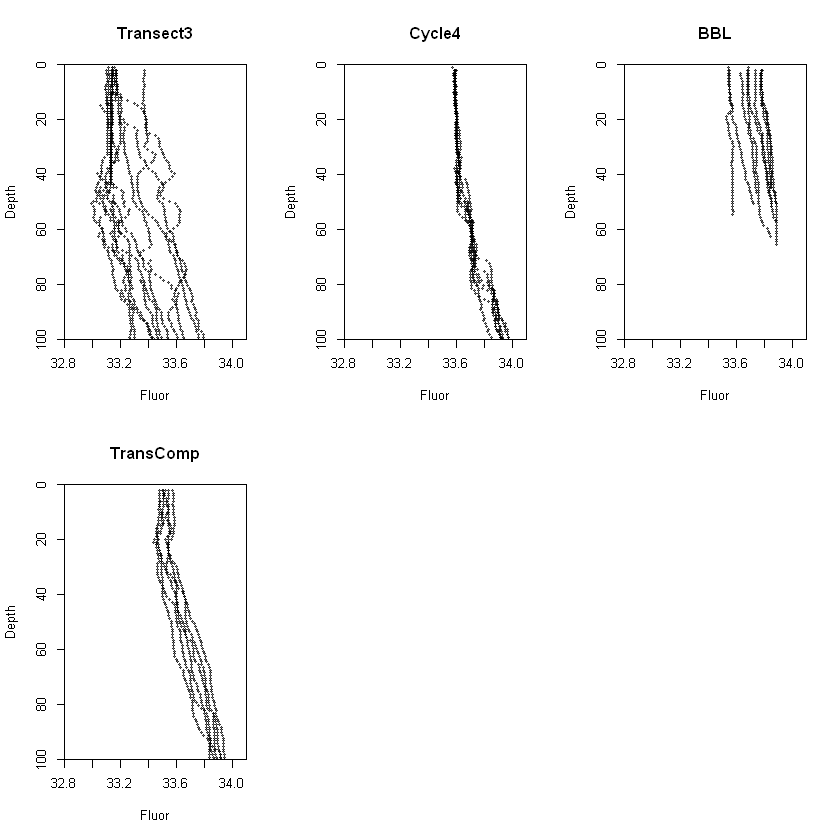

In [65]:
#pdf('Output/CTD/CTD Module - Summary of Sal Profiles per Cycle.pdf')
#png('Output/CTD/CTD Module - Summary of Sal Profiles per Cycle.png')

par(mfrow=c(2,3))
for (i in unique(ctd$Cycle)) {
    plot.cycle(i)
}

#dev.off()

In [11]:
get.cast = function(cast, dir = 'down') {
    l = which(ctd$Cast == cast & ctd$Direction == dir)
    ctd[l,]
}

get.avg.temp = function(cast, mld) {
    l = which(ctd$Cast == cast & ctd$Direction == 'down')
    trap.integrate(ctd$Depth[l], ctd$T090C[l], mld)
}

get.avg.S = function(cast, mld) {
    l = which(ctd$Cast == cast & ctd$Direction == 'down')
    trap.integrate(ctd$Depth[l], ctd$Sal00[l], mld)
}


calc.cycle.avg = function(time = '2 am') {
    data = data.frame(Cycle = '', Cast = '', T = 0, S = 0, stringsAsFactors = FALSE)
    
    casts.times = which(ctd.log$Station.Type == time)

    for (i in unique(ctd.log$Cycle)) {
        l = which(ctd.log$Cycle == i)
        k = intersect(casts.times, l)  ## Which entries do we care about (cycle + 2am)

        if (length(k) > 0) {
            casts = ctd.log$Cast[k] ## Which casts

            for (j in casts) {  ## for each cast
                cast.mld = mld$mld[which(mld$Cast == j)]
                data = rbind(data, c(i, j, get.avg.temp(j, cast.mld), get.avg.S(j, cast.mld)))
            }   
        }
    }
    data = data[-1,]
    data
}

get.flow.T = function(data, flow.time, flow, t.window = 12, d, d.max = 1e3) {
    m = c()
    s = c()
    n = c()
    for (i in 1:nrow(data)) {
        cast.time = conv_excel_time(ctd.log$DateTime_GMT[which(data$Cast[i] == ctd.log$Cast)])
        dt = as.numeric(difftime(cast.time, flow.time, units = 'hours'))
        l = which(dt^2 < t.window^2)
        ld = which(d[l] < d.max)
        
        if (length(ld) < 1) {
            m = c(m, 0)
            s = c(s, 0)
            n = c(n, 0)
        } else {
            m = c(m, mean(flow[l[ld]], na.rm = TRUE))
            s = c(s, sd(flow[l[ld]], na.rm = TRUE))
            n = c(n, length(ld))
        }
    }
    if (any(n == 0)) {
        cat('Some temperature sets contained 0 elements.')
    }
    list(m = m, s = s, n = n)
}

In [24]:
d.max = 1

temp = calc.cycle.avg()
inlet = get.flow.T(data = temp, flow.time = ship.data$DT[ship.data$EIMS.Inlet.T.FLAG < 3],
                   flow = ship.data$EIMS.Inlet.T[ship.data$EIMS.Inlet.T.FLAG < 3],
                   d = ship.data$Dist.to.Drifter, d.max = d.max, t.window = 24)

ship = get.flow.T(temp, ship.data$DT, ship.data$TT, d = ship.data$Dist.to.Drifter, d.max = d.max)

mims = get.flow.T(temp, ship.data$DT[ship.data$Optode.temp2.FLAG < 3],
                  ship.data$Optode.temp2[ship.data$Optode.temp2.FLAG < 3],
                  d = ship.data$Dist.to.Drifter, d.max = d.max)

temp$Inlet.m = inlet$m
temp$Inlet.s = inlet$s
temp$MIMS.m = mims$m
temp$MIMS.s = mims$s
temp$ship.m = ship$m
temp$ship.s = ship$s

temp

Some temperature sets contained 0 elements.

,Cycle,Cast,T,S,Inlet.m,Inlet.s,MIMS.m,MIMS.s,ship.m,ship.s
2,Cycle1,15,12.5038264373117,33.7545865158583,0.00000,0.00000000,13.56415,0.31161124,13.41756,0.34141417
3,Cycle1,22,12.9782991309515,33.744021495679,12.52069,0.15085058,13.46199,0.05310743,13.28314,0.05682073
4,Cycle1,24,12.526264802464,33.7259638319504,13.06673,0.83826888,13.12805,0.12147528,12.95811,0.13268350
5,Cycle2,25,12.9063678842944,33.6415778712034,13.76085,0.76325854,13.24459,0.04971523,13.07105,0.05023422
6,Cycle2,29,12.7050323110465,33.6344850579869,12.42691,0.05044219,13.53777,1.00198256,13.08884,0.04274724
7,Cycle2,31,12.801530176045,33.6410344454427,12.47417,0.06526273,13.32151,0.03239125,13.19164,0.02857763
8,Cycle2,33,12.8278669929425,33.6235585159267,12.67101,0.18080730,13.46909,0.42071890,13.35747,0.04400221
9,Cycle2,36,13.0147997490064,33.631906327745,13.26379,0.54288018,13.69936,0.04326343,13.50001,0.05187758
10,Cycle3,48,13.6102196003563,33.2941101693472,13.54125,0.11007344,14.50349,0.04522014,14.15469,0.11171248
11,Cycle3,52,15.1426305386183,33.1269746049012,14.95268,0.28031024,15.69302,0.53019698,15.23607,0.52610759


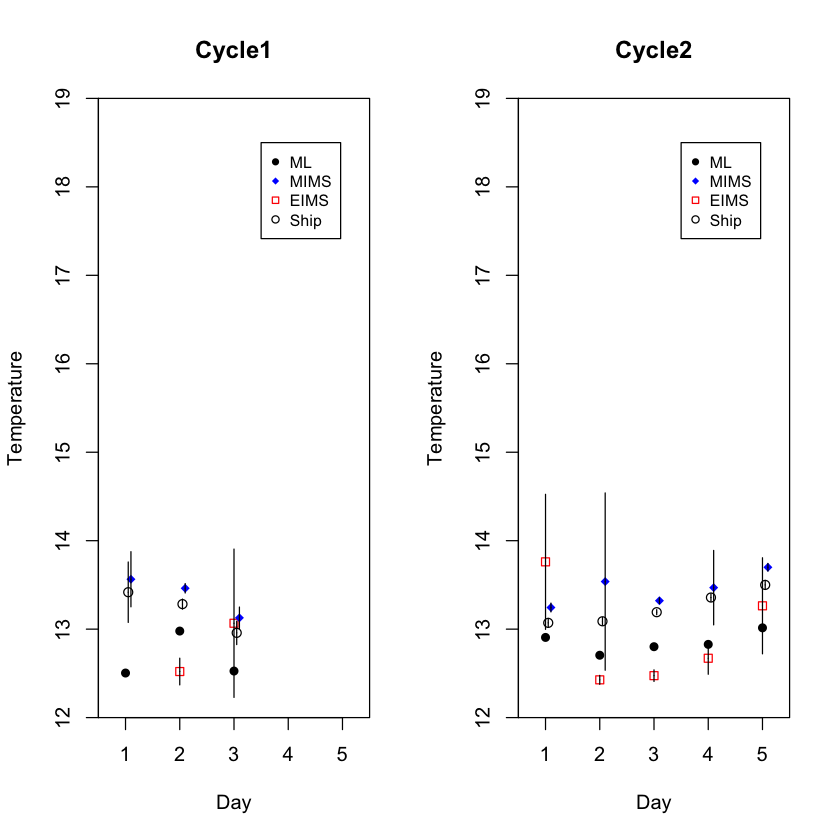

null device 
          1

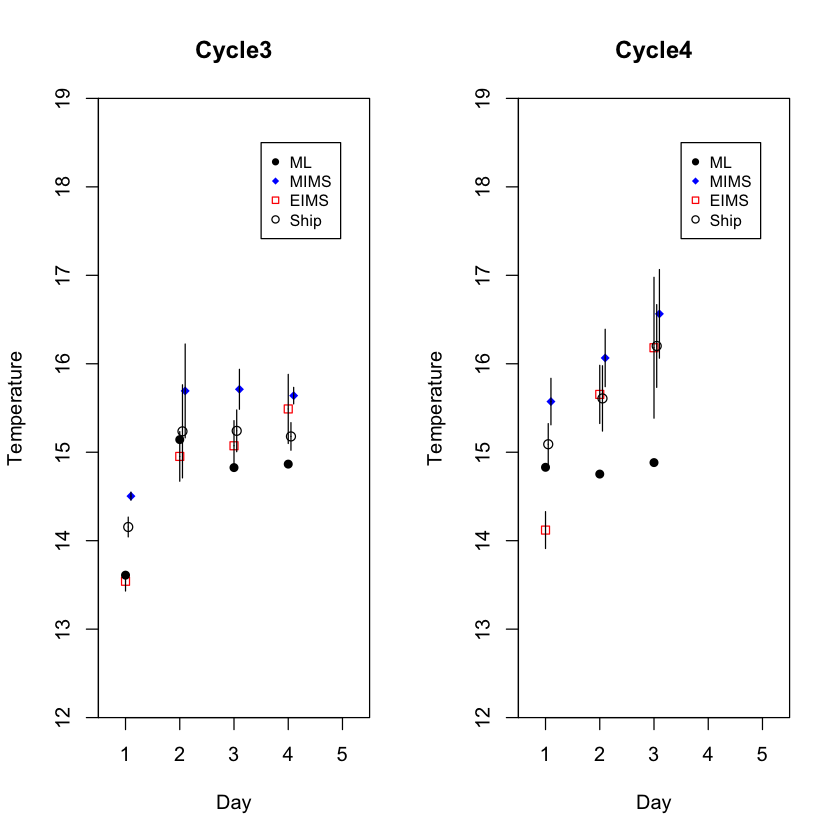

In [28]:
#pdf('Output/CTD Module - T per day summary (<1km).pdf')
#png('Output/CTD Module - T per day summary (<1km).png')
plot.day.summary = function(temp) {
    par(mfrow=c(1,2))
    for (i in unique(temp$Cycle)) {
        l = which(temp$Cycle == i)
        plot(NULL, NULL, ylim=c(12,19), xlim=c(0.5, 5.5), xaxs='i', yaxs='i', ylab='Temperature', xlab='Day', main=i)

        for (j in 1:length(l)) {
            points(j, temp$Inlet.m[l[j]], col='red', pch=22)
            add.error.bars(j, 0, temp$Inlet.m[l[j]], temp$Inlet.s[l[j]])

            points(j+0.1, temp$MIMS.m[l[j]], col = 'blue', pch=18)
            add.error.bars(j+0.1, 0, temp$MIMS.m[l[j]], temp$MIMS.s[l[j]])

            points(j+0.05, temp$ship.m[l[j]], col = 'black', pch=1)
            add.error.bars(j+0.05, 0, temp$ship.m[l[j]], temp$ship.s[l[j]])

            points(j, temp$T[l[j]], pch=16)
        }
        legend(3.5, 18.5, c('ML', 'MIMS', 'EIMS', 'Ship'), col=c('black', 'blue', 'red', 'black'),
               pch=c(16, 18, 22, 1), cex=0.8)
    }
}
plot.day.summary(temp)
dev.off()

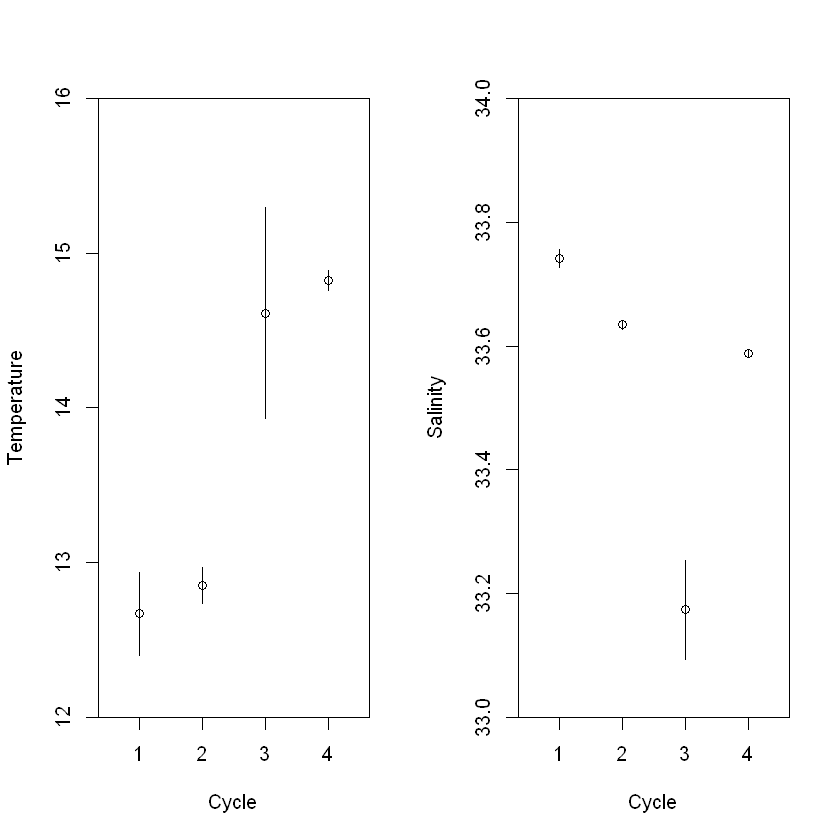

In [6]:
#pdf('Output/CTD Module - T and S cycle summary.pdf')
#png('Output/CTD Module - T and S cycle summary.png')

T.m = c()
T.s = c()
S.m = c()
S.s = c()

for (i in unique(temp$Cycle)) {
    l = which(temp$Cycle == i)
    
    T.m = c(T.m, mean(as.numeric(temp$T[l])))
    T.s = c(T.s, sd(temp$T[l]))
    S.m = c(S.m, mean(as.numeric(temp$S[l])))
    S.s = c(S.s, sd(temp$S[l]))
}
par(mfrow=c(1,2))

## Temperature
plot(NULL, NULL, xlim = c(0.5, 4.5), ylim = c(12, 16), ylab='Temperature', xlab='Cycle', yaxs='i')
points(c(1:4), T.m)
add.error.bars(c(1:4), rep(0,4), T.m, T.s)

## Salinity
plot(NULL, NULL, xlim = c(0.5, 4.5), ylim = c(33, 34), ylab='Salinity', xlab='Cycle', yaxs='i')
points(c(1:4), S.m)
add.error.bars(c(1:4), rep(0,4), S.m, S.s)

#dev.off()